In [3]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import qsdsan as qs
import biosteam as bst
import os
# os.environ["PATH"] += os.pathsep + r'C:\Users\ajs8911\Miniconda3\envs\bw2\Library\bin' # (work) required to get graphviz system diagrams to save 
os.environ["PATH"] += os.pathsep + r'C:\Users\adsme\miniconda3\envs\bw2\Library\bin' # (home) required to get graphviz system diagrams to save 

In [4]:
#  Setup Components
Calcium_sulfate_dihydrate = qs.Chemical(ID='Calcium_sulfate_dihydrate', 
CAS=10101-41-4, 
search_db=True, 
phase='s', 
rho=2320, #         https://pubchem.ncbi.nlm.nih.gov/compound/24928
Cp=186.2/172.171, #           http://chemister.ru/Database/properties-en.php?dbid=1&id=552
Hf=-2021.1*1000) #          http://chemister.ru/Database/properties-en.php?dbid=1&id=552

Cerium = qs.Chemical(ID='Cerium', 
CAS=7440-45-1, 
search_db=True, 
phase='s', 
rho=6770, # kg/m3              https://pubchem.ncbi.nlm.nih.gov/element/Cerium#section=Atomic-Spectra
Cp=0.188, # J/g/K          https://www.matweb.com/search/datasheet_print.aspx?matguid=431c79b473df430087f7581fd8b064bc
Tc=9511, # copied from La
Pc=5.46e+08, # copied from La
Vc=3.65e-05,
V=1/(6770/140.116))

cmps_default = qs.Components.load_default()
Lanthanum = qs.Component('La', search_ID='7439-91-0', particle_size = 'Soluble', degradability='Undegradable', organic=False)
# Cerium = qs.Component('Ce', search_ID='7440-45-1', particle_size = 'Soluble', degradability='Undegradable', organic=False)
# Cerium = qs.Component('Ce', search_ID='7440-45-1', particle_size = 'Soluble', degradability='Undegradable', organic=False)
Cerium = qs.Component.from_chemical('Ce', chemical=Cerium, particle_size = 'Soluble', degradability='Undegradable', organic=False)
Praseodymium = qs.Component('Pr', search_ID='7440-10-0', particle_size = 'Soluble', degradability='Undegradable', organic=False)
Neodymium = qs.Component('Nd', search_ID='7440-00-8', particle_size = 'Soluble', degradability='Undegradable', organic=False)
Gypsum = qs.Component.from_chemical('Gypsum', chemical=Calcium_sulfate_dihydrate, particle_size = 'Particulate', degradability='Undegradable', organic=False)
H2SO4 = qs.Component('H2SO4', search_ID='7664-93-9', particle_size = 'Soluble', degradability='Undegradable', organic=False)
cmps = qs.Components([*cmps_default, Lanthanum, Cerium, Praseodymium, Neodymium, Gypsum, H2SO4])
qs.set_thermo(cmps)
cmps
# Lanthanum.show(chemical_info=True)


CompiledComponents([S_H2, S_CH4, S_CH3OH, S_Ac, S_Prop, S_F, S_U_Inf, S_U_E, C_B_Subst, C_B_BAP, C_B_UAP, C_U_Inf, X_B_Subst, X_OHO_PHA, X_GAO_PHA, X_PAO_PHA, X_GAO_Gly, X_PAO_Gly, X_OHO, X_AOO, X_NOO, X_AMO, X_PAO, X_MEOLO, X_FO, X_ACO, X_HMO, X_PRO, X_U_Inf, X_U_OHO_E, X_U_PAO_E, X_Ig_ISS, X_MgCO3, X_CaCO3, X_MAP, X_HAP, X_HDP, X_FePO4, X_AlPO4, X_AlOH, X_FeOH, X_PAO_PP_Lo, X_PAO_PP_Hi, S_NH4, S_NO2, S_NO3, S_PO4, S_K, S_Ca, S_Mg, S_CO3, S_N2, S_O2, S_CAT, S_AN, H2O, La, Ce, Pr, Nd, Gypsum, H2SO4])


In [5]:
class Adsorption1(qs.SanUnit):
    def __init__(self, ID='S1', ins=None, outs=(), thermo=None, init_with='SanStream',
    c1o = 0.01, # 
    c2o = 0.01, # 
    feed_flow = 1/1000 #
    ):
        # Some standard codes you need to include for all subclasses of `SanUnit`
        qs.SanUnit.__init__(self, ID, ins, outs, thermo, init_with)

        # These are the unique attributes 
        self.c1o = c1o
        self.c2o = c2o
        self.feed_flow = feed_flow
        
    _N_ins = 7
    _N_outs = 2

    def _run(self):
        # Set fresh feed and regenerant flow rates
        # fresh feed
        self.ins[0].imol['La'] = self.c1o*self.feed_flow /1000/1000*60 # kmol/hr. from mmol/min
        self.ins[0].imol['Ce'] = self.c2o*self.feed_flow /1000/1000*60 # kmol/hr. from mmol/min
        self.ins[0].ivol['H2O'] = self.feed_flow /1000*60 # m3/hr. from L/min
        # regenerant 
        self.ins[1].ivol['H2O'] = self.ins[0].ivol['H2O'] # m3/hr. Regenerant (water) flow rate. Assume regeneration takes the same amount of adsorption (higher flow rate here leads to better adsorbate purity)
        
        # self.CM1o = (self.ins[0].imol['La']*1000 + self.ins[2].imol['La']*1000 + self.ins[3].imol['La']*1000 + self.ins[4].imol['La']*1000)/(self.ins[0].ivol['H2O']*1000 + self.ins[2].ivol['H2O']*1000 + self.ins[3].ivol['H2O']*1000 + self.ins[4].ivol['H2O']*1000)*1000 # inlet concentration in mmol/L
        # self.CM2o = (self.ins[0].imol['Ce']*1000 + self.ins[2].imol['Ce']*1000 + self.ins[3].imol['Ce']*1000 + self.ins[4].imol['Ce']*1000)/(self.ins[0].ivol['H2O']*1000 + self.ins[2].ivol['H2O']*1000 + self.ins[3].ivol['H2O']*1000 + self.ins[4].ivol['H2O']*1000)*1000 # inlet concentration in mmol/L
        # self.v_flow = (self.ins[0].ivol['H2O'] + self.ins[2].ivol['H2O'] + self.ins[3].ivol['H2O'] + self.ins[4].ivol['H2O'])*1000/60 # L/min

        self.v_flow = (np.sum([i.ivol['H2O'] for i in self.ins]) - self.ins[1].ivol['H2O'])*1000/60 # L/min
        self.CM1o = (np.sum([i.imol['La'] for i in self.ins]) - self.ins[1].imol['La'])*1000*1000/(self.v_flow*60) # inlet concentration in mmol/L
        self.CM2o = (np.sum([i.imol['Ce'] for i in self.ins]) - self.ins[1].imol['Ce'])*1000*1000/(self.v_flow*60) # inlet concentration in mmol/L

        # Input data
        self.Qmax1 = 0.3  # [mmol Ln/mmol membrane] maximum adsorption capacity based on number of available binding sites
        kon1 = 50  # [1/mM/min] forward kinetic constant for CM
        KL1 = 40  # [mM^-1] Thermodynamic stability constant 

        Qmax2 = 0.3  # [mmol Ln/mmol membrane] maximum adsorption capacity based on number of available binding sites
        kon2 = 50  # [1/mM/min] forward kinetic constant for CM2
        KL2 = 400  # [mM^-1] Thermodynamic stability constant 

        eps = 0.78  # porosity of the membrane 
        self.rhop = 1  # [mmol/cm^3] density of the polymer substrate 
        self.u = 0.065  # [cm/min] chosen flow velocity (1 cm3/min)
                
        koff1 = kon1 / KL1  # [1/min] reverse kinetic constant for CM
        koff2 = kon2 / KL2  # [1/min] reverse kinetic constant for CM2

        # Increment for Length
        self.L = 0.2  # [cm] thickness of membrane
        Nz = 31  # number of steps for thickness
        z = np.linspace(0, self.L, Nz)  # generate a list filled with 11 equally spaced steps of thicknesses from 0 to L
        # z = np.concatenate([np.linspace(0, 0.18, 10), np.linspace(0.18, self.L, 10)])
        # Nz = len(z)
        dz = z[1] - z[0]  # [cm] step size

        # Time
        t = np.arange(0, 100, 0.01)  # [min] create a list from 0 to 30 in 0.25 increments

        # Initial conditions
        IC1a = np.zeros(Nz)
        IC1b = np.zeros(Nz)
        IC2a = np.zeros(Nz)
        IC2b = np.zeros(Nz)
        IC = np.concatenate((IC1a, IC1b, IC2a, IC2b))

        # Function for the ODE
        def f(t, y):
            dCMdt = np.zeros(Nz)
            dQtdt = np.zeros(Nz)
            dCM2dt = np.zeros(Nz)
            dQt2dt = np.zeros(Nz)

            # Define values
            CM = y[:Nz]
            Qt = y[Nz:2*Nz]
            CM2 = y[2*Nz:3*Nz]
            Qt2 = y[3*Nz:]

            # Boundary conditions (index for z-dimension)
            CM[0] = self.CM1o
            CM[-1] = (4 * CM[-2] - CM[-3]) / 3  # Use backward second order error
            CM2[0] = self.CM2o
            CM2[-1] = (4 * CM2[-2] - CM2[-3]) / 3  # Use backward second order error

            # Interior
            for i in range(1, Nz - 1):  # material balance between solid adsorbent and liquid feed
                # assume negligible mass transfer resistances, heat generation, first order kinetics

                # Kinetic derivation (accounts for both thermo (kL=kon/koff) and kinetic (value of kon) impacts on breakthrough)
                dQtdt[i] = kon1 * CM[i] * (self.Qmax1 - Qt[i] - Qt2[i]) - koff1 * Qt[i] # amount bound to the adsorbent bed. 
                dQt2dt[i] = kon2 * CM2[i] * (Qmax2 - Qt[i] - Qt2[i]) - koff2 * Qt2[i] # amount bound to the adsorbent bed. 

                # # Thermo derivation (only accounts for the thermo impact on breakthrough. Values of kon had no effect.)
                # Qe1 = Qmax1*(kon1/koff1)*CM[i]/(1 + (kon2/koff2)*CM2[i] + (kon1/koff1)*CM[i]) # mmol U/g membrane. 
                # Qe2 = Qmax2*(kon2/koff2)*CM2[i]/(1 + (kon2/koff2)*CM2[i] + (kon1/koff1)*CM[i])  # mmol La/g membrane. 
                # dQtdt[i] = Qe1 - Qt[i]  # amount bound to the adsorbent bed
                # dQt2dt[i] = Qe2 - Qt2[i]  # amount bound to the adsorbent bed for CM2

                dCMdz = (CM[i + 1] - CM[i - 1]) / (2 * dz)  # amount in solution adsorbed to the bed
                dCM2dz = (CM2[i + 1] - CM2[i - 1]) / (2 * dz)  # amount in solution adsorbed to the bed for CM2
                dCMdt[i] = -self.u * dCMdz - self.rhop * ((1 - eps) / eps) * dQtdt[i]  # amount in the liquid
                dCM2dt[i] = -self.u * dCM2dz - self.rhop * ((1 - eps) / eps) * dQt2dt[i]  # amount in the liquid for CM2

            return np.concatenate((dCMdt, dQtdt, dCM2dt, dQt2dt))

        # Solve ODE
        sol = solve_ivp(fun=f, t_span=(min(t), max(t)), y0=IC, t_eval=t, method='RK23') # , method='RK45', rtol=1e-6, atol=1e-9
            
        # Extract results
        CM = sol.y[:Nz].T  # solution is time points x depths into the membrane thickness
        Qt = sol.y[Nz:2*Nz].T  # Due to concatenation in the function, C and Q values are stored for each membrane thickness
        CM2 = sol.y[2*Nz:3*Nz].T  # solution is time points x depths into the membrane thickness for CM2
        Qt2 = sol.y[3*Nz:].T  # Due to concatenation in the function, C and Q values are stored for each membrane thickness for CM2

        # Reinput BC (index for t)
        CM[0] = 0
        CM[-1] = (4 * CM[-2] - CM[-3]) / 3  # Use backward second order error
        Qt[-1] = (4 * Qt[-2] - Qt[-3]) / 3  # Use backward second order error
        CM2[0] = 0
        CM2[-1] = (4 * CM2[-2] - CM2[-3]) / 3  # Use backward second order error
        Qt2[-1] = (4 * Qt2[-2] - Qt2[-3]) / 3  # Use backward second order error

        # Make callable for results
        self.conc1 = CM
        self.conc2 = CM2
        self.Qads1 = Qt
        self.Qads2 = Qt2
        self.time= t

        for k in range(1, len(CM2[:,-2])-1):
            if (CM2[k,-2]/self.CM2o) > 0.20: # stop adsorption at 20% breakthrough of component 2
                self.tbreak = t[k]
                nM1_in = np.trapz(y=[self.CM1o]*len(t[:k]), x=t[:k])*self.v_flow # mmol La. Amount of Ln entering the unit. Calculated by taking area under initial conc. curve on conc. v time plot
                nM2_in = np.trapz(y=[self.CM2o]*len(t[:k]), x=t[:k])*self.v_flow # mmol Ce. Amount of Ln entering the unit. Calculated by taking area under initial conc. curve on conc. v time plot
                nM1_break = np.trapz(y=CM[:k,-2], x=t[:k])*self.v_flow # mmol La. Amount of Ln exiting the unit after breakthrough. Calculated as area under component outlet conc. curve on conc. v time plot
                nM2_break = np.trapz(y=CM2[:k,-2], x=t[:k])*self.v_flow # mmol Ce. Amount of Ln exiting the unit after breakthrough. Calculated as area under component outlet conc. curve on conc. v time plot
                nM1_ads = nM1_in - nM1_break # mmol La. Amount of Ln adsorbed to solid phase. Calculated as area of conc. v time plot between the initial concentration in curve and the component outlet conc. curve
                nM2_ads = nM2_in - nM2_break # mmol Ce. Amount of Ln adsorbed to solid phase. Calculated as area of conc. v time plot between the initial concentration in curve and the component outlet conc. curve
                self.tag = 'start'
                break

        # Set inlet/outlet flows
        self.outs[0].imol['La'] = nM1_break/self.tbreak /1000/1000*60 # kmol/hr. from mmol/min
        self.outs[0].imol['Ce'] = nM2_break/self.tbreak /1000/1000*60 # kmol/hr. from mmol/min
        self.outs[0].ivol['H2O'] = self.v_flow /1000*60 # m3/hr. from L/min
        
        self.outs[1].imol['La'] = nM1_ads/self.tbreak /1000/1000*60 # kmol/hr. from mmol/min
        self.outs[1].imol['Ce'] = nM2_ads/self.tbreak /1000/1000*60 # kmol/hr. from mmol/min
        self.outs[1].ivol['H2O'] = self.ins[1].ivol['H2O'] # m3/hr. from L/min. Assume regeneration takes 1/4 as long as adsorption (use acid instead, what conc?, how does recycle change pH)


    _units = {
        'Breakthrough Time': 'min',
        'Volumetric Flow Rate': 'L/min'
    }

    def _design(self):
        D = self.design_results
        D['Time'] = self.time
        D['Breakthrough Time'] = self.tbreak 
        D['Initial Conc La'] = self.CM1o
        D['Initial Conc Ce'] = self.CM2o
        D['Conc La'] = self.conc1
        D['Conc Ce'] = self.conc2    
        D['Adsorbed La'] = self.Qads1
        D['Adsorbed Ce'] = self.Qads2

    def _cost(self):
        membrane_area = self.v_flow/self.u # cm2
        membrane_volume = membrane_area*self.L # cm3 Should I consider porosity here?
        # Qmax1 # [mmol Ln/mmol membrane] maximum adsorption capacity based on number of available binding sites. Assume 1:1 binding of Ln to peptide
        # rhop # [mmol/cm^3] density of the polymer substrate 
        MW_peptide = 11.800 # g/mmol. molecular weight of the LanM protein
        g_peptide = membrane_volume*self.rhop*self.Qmax1*MW_peptide # g peptide. Assume 1:1 binding of Ln to peptide
        peptide_price = 0.5 # $/g biomolecule. from multiple sources of protein and peptide data
        cost_peptide = g_peptide*peptide_price # $
        MW_substrate = 250 # g/mmol molecular weight of the LanM protein. assumed PP
        substrate_price = 0.001 # $/g substrate
        cost_substrate = membrane_volume*self.rhop*MW_substrate*substrate_price
        self.baseline_purchase_costs['Adsorption1'] = (cost_peptide + cost_substrate) * 2 # need at least two units for cycling
        

In [6]:
class Adsorption5(qs.SanUnit):
    def __init__(self, ID='', ins=None, outs=(), thermo=None, init_with='SanStream',
    stuff = 1/1000 # 
    ):
        # Some standard codes you need to include for all subclasses of `SanUnit`
        qs.SanUnit.__init__(self, ID, ins, outs, thermo, init_with)

        # These are the unique attributes 
        self.stuff = stuff
        
    _N_ins = 2
    _N_outs = 2

    def _run(self):
        
        # Set Inlet Flows and Concentrations
        self.ins[1].ivol['H2O'] = self.ins[0].ivol['H2O'] # m3/hr. Regenerant (water) flow rate. Converted from L/min to m3/hr
        
        self.CM1o = self.ins[0].imol['La']*1000/(self.ins[0].ivol['H2O']*1000)*1000 # inlet concentration in mmol/L
        self.CM2o = self.ins[0].imol['Ce']*1000/(self.ins[0].ivol['H2O']*1000)*1000 # inlet concentration in mmol/L

        self.v_flow = self.ins[0].ivol['H2O']*1000/60 # L/min. Assumed volumetric flow rate

        # Set input values
        self.Qmax1 = 0.3  # [mmol Ln/mmol membrane] maximum adsorption capacity based on number of available binding sites
        kon1 = 50  # [1/mM/min] forward kinetic constant for CM
        KL1 = 40  # [mM^-1] Thermodynamic stability constant 

        Qmax2 = 0.3  # [mmol Ln/mmol membrane] maximum adsorption capacity based on number of available binding sites
        kon2 = 50  # [1/mM/min] forward kinetic constant for CM2
        KL2 = 400  # [mM^-1] Thermodynamic stability constant 

        eps = 0.78  # porosity of the membrane 
        self.rhop = 1  # [mmol/cm^3] density of the polymer substrate 
        self.u = 0.065  # [cm/min] chosen flow velocity (1 cm3/min)
        
        koff1 = kon1 / KL1  # [1/min] reverse kinetic constant for CM
        koff2 = kon2 / KL2  # [1/min] reverse kinetic constant for CM2

        # Increment for Length
        self.L = 0.1  # [cm] thickness of membrane
        Nz = 31  # number of steps for thickness
        z = np.linspace(0, self.L, Nz)  # generate a list filled with 11 equally spaced steps of thicknesses from 0 to L
        # z = np.concatenate([np.linspace(0, 0.18, 10), np.linspace(0.18, self.L, 10)])
        # Nz = len(z)
        dz = z[1] - z[0]  # [cm] step size

        # Time
        t = np.arange(0, 100, 0.01)  # [min] create a list from 0 to 30 in 0.25 increments

        # Initial conditions
        IC1a = np.zeros(Nz)
        IC1b = np.zeros(Nz)
        IC2a = np.zeros(Nz)
        IC2b = np.zeros(Nz)
        IC = np.concatenate((IC1a, IC1b, IC2a, IC2b))

        # Function for the ODE
        def f(t, y):
            dCMdt = np.zeros(Nz)
            dQtdt = np.zeros(Nz)
            dCM2dt = np.zeros(Nz)
            dQt2dt = np.zeros(Nz)

            # Define values
            CM = y[:Nz]
            Qt = y[Nz:2*Nz]
            CM2 = y[2*Nz:3*Nz]
            Qt2 = y[3*Nz:]

            # Boundary conditions (index for z-dimension)
            CM[0] = self.CM1o
            CM[-1] = (4 * CM[-2] - CM[-3]) / 3  # Use backward second order error
            CM2[0] = self.CM2o
            CM2[-1] = (4 * CM2[-2] - CM2[-3]) / 3  # Use backward second order error

            # Interior
            for i in range(1, Nz - 1):  # material balance between solid adsorbent and liquid feed
                # assume negligible mass transfer resistances, heat generation, first order kinetics

                # Kinetic derivation (accounts for both thermo (kL=kon/koff) and kinetic (value of kon) impacts on breakthrough)
                dQtdt[i] = kon1 * CM[i] * (self.Qmax1 - Qt[i] - Qt2[i]) - koff1 * Qt[i] # amount bound to the adsorbent bed. 
                dQt2dt[i] = kon2 * CM2[i] * (Qmax2 - Qt[i] - Qt2[i]) - koff2 * Qt2[i] # amount bound to the adsorbent bed. 

                # # Thermo derivation (only accounts for the thermo impact on breakthrough. Values of kon had no effect.)
                # Qe1 = Qmax1*(kon1/koff1)*CM[i]/(1 + (kon2/koff2)*CM2[i] + (kon1/koff1)*CM[i]) # mmol U/g membrane. 
                # Qe2 = Qmax2*(kon2/koff2)*CM2[i]/(1 + (kon2/koff2)*CM2[i] + (kon1/koff1)*CM[i])  # mmol La/g membrane. 
                # dQtdt[i] = Qe1 - Qt[i]  # amount bound to the adsorbent bed
                # dQt2dt[i] = Qe2 - Qt2[i]  # amount bound to the adsorbent bed for CM2

                dCMdz = (CM[i + 1] - CM[i - 1]) / (2 * dz)  # amount in solution adsorbed to the bed
                dCM2dz = (CM2[i + 1] - CM2[i - 1]) / (2 * dz)  # amount in solution adsorbed to the bed for CM2
                dCMdt[i] = -self.u * dCMdz - self.rhop * ((1 - eps) / eps) * dQtdt[i]  # amount in the liquid
                dCM2dt[i] = -self.u * dCM2dz - self.rhop * ((1 - eps) / eps) * dQt2dt[i]  # amount in the liquid for CM2

            return np.concatenate((dCMdt, dQtdt, dCM2dt, dQt2dt))

        # Solve ODE
        sol = solve_ivp(fun=f, t_span=(min(t), max(t)), y0=IC, t_eval=t, method='RK23') # , method='RK45', rtol=1e-6, atol=1e-9
            
        # Extract results
        CM = sol.y[:Nz].T  # solution is time points x depths into the membrane thickness
        Qt = sol.y[Nz:2*Nz].T  # Due to concatenation in the function, C and Q values are stored for each membrane thickness
        CM2 = sol.y[2*Nz:3*Nz].T  # solution is time points x depths into the membrane thickness for CM2
        Qt2 = sol.y[3*Nz:].T  # Due to concatenation in the function, C and Q values are stored for each membrane thickness for CM2

        # Reinput BC (index for t)
        CM[0] = 0
        CM[-1] = (4 * CM[-2] - CM[-3]) / 3  # Use backward second order error
        Qt[-1] = (4 * Qt[-2] - Qt[-3]) / 3  # Use backward second order error
        CM2[0] = 0
        CM2[-1] = (4 * CM2[-2] - CM2[-3]) / 3  # Use backward second order error
        Qt2[-1] = (4 * Qt2[-2] - Qt2[-3]) / 3  # Use backward second order error

        # Make callable for results
        self.conc1 = CM
        self.conc2 = CM2
        self.Qads1 = Qt
        self.Qads2 = Qt2
        self.time= t

        nM1_in = np.trapz(y=[self.CM1o]*len(t[:]), x=t[:])*self.v_flow # mmol La. Amount of Ln entering the unit. Calculated by taking area under initial conc. curve on conc. v time plot
        nM2_in = np.trapz(y=[self.CM2o]*len(t[:]), x=t[:])*self.v_flow # mmol Ce. Amount of Ln entering the unit. Calculated by taking area under initial conc. curve on conc. v time plot
        nM1_break_final = np.trapz(y=CM[:,-2], x=t[:])*self.v_flow # mmol La. Amount of Ln exiting the unit after breakthrough. Calculated as area under component outlet conc. curve on conc. v time plot
        nM2_break_final = np.trapz(y=CM2[:,-2], x=t[:])*self.v_flow # mmol Ce. Amount of Ln exiting the unit after breakthrough. Calculated as area under component outlet conc. curve on conc. v time plot
        nM1_ads_final = nM1_in - nM1_break_final # mmol La. Amount of Ln adsorbed to solid phase. Calculated as area of conc. v time plot between the initial concentration in curve and the component outlet conc. curve
        nM2_ads_final = nM2_in - nM2_break_final # mmol Ce. Amount of Ln adsorbed to solid phase. Calculated as area of conc. v time plot between the initial concentration in curve and the component outlet conc. curve
        if (nM2_ads_final + 0.000000001)/(nM2_ads_final + nM1_ads_final + 0.000000001) > 0.99:
            for k in range(4, len(CM2[:,-2])-4):
                nM1_in = np.trapz(y=[self.CM1o]*len(t[:k]), x=t[:k])*self.v_flow # mmol La. Amount of Ln entering the unit. Calculated by taking area under initial conc. curve on conc. v time plot
                nM2_in = np.trapz(y=[self.CM2o]*len(t[:k]), x=t[:k])*self.v_flow # mmol Ce. Amount of Ln entering the unit. Calculated by taking area under initial conc. curve on conc. v time plot
                nM1_break = np.trapz(y=CM[:k,-2], x=t[:k])*self.v_flow # mmol La. Amount of Ln exiting the unit after breakthrough. Calculated as area under component outlet conc. curve on conc. v time plot
                nM2_break = np.trapz(y=CM2[:k,-2], x=t[:k])*self.v_flow # mmol Ce. Amount of Ln exiting the unit after breakthrough. Calculated as area under component outlet conc. curve on conc. v time plot
                nM1_ads = nM1_in - nM1_break # mmol La. Amount of Ln adsorbed to solid phase. Calculated as area of conc. v time plot between the initial concentration in curve and the component outlet conc. curve
                nM2_ads = nM2_in - nM2_break # mmol Ce. Amount of Ln adsorbed to solid phase. Calculated as area of conc. v time plot between the initial concentration in curve and the component outlet conc. curve

                if (nM2_ads + 0.00000001)/(nM2_ads + nM1_ads + 0.00000001) > 0.99:
                    self.tbreak = t[k]
                    self.tag = 'pure Ce'
                    break
        else:
            for k in range(1, len(CM2[:,-2])-1):
                nM1_in = np.trapz(y=[self.CM1o]*len(t[:k]), x=t[:k])*self.v_flow # mmol La. Amount of Ln entering the unit. Calculated by taking area under initial conc. curve on conc. v time plot
                nM2_in = np.trapz(y=[self.CM2o]*len(t[:k]), x=t[:k])*self.v_flow # mmol Ce. Amount of Ln entering the unit. Calculated by taking area under initial conc. curve on conc. v time plot
                nM1_break = np.trapz(y=CM[:k,-2], x=t[:k])*self.v_flow # mmol La. Amount of Ln exiting the unit after breakthrough. Calculated as area under component outlet conc. curve on conc. v time plot
                nM2_break = np.trapz(y=CM2[:k,-2], x=t[:k])*self.v_flow # mmol Ce. Amount of Ln exiting the unit after breakthrough. Calculated as area under component outlet conc. curve on conc. v time plot
                nM1_ads = nM1_in - nM1_break # mmol La. Amount of Ln adsorbed to solid phase. Calculated as area of conc. v time plot between the initial concentration in curve and the component outlet conc. curve
                nM2_ads = nM2_in - nM2_break # mmol Ce. Amount of Ln adsorbed to solid phase. Calculated as area of conc. v time plot between the initial concentration in curve and the component outlet conc. curve

                if (CM2[k,-2]/self.CM2o) > 0.90:
                        self.tbreak = t[k]
                        self.tag = 'purifying Ce'
                        break

        # Set outlet flows
        # diluate
        self.outs[0].imol['La'] = nM1_break/self.tbreak /1000/1000*60 # kmol/hr. from mmol/min
        self.outs[0].imol['Ce'] = nM2_break/self.tbreak /1000/1000*60 # kmol/hr. from mmol/min
        self.outs[0].ivol['H2O'] = self.ins[0].ivol['H2O'] # m3/hr. from L/min
        # adsorbate
        self.outs[1].imol['La'] = nM1_ads/self.tbreak /1000/1000*60 # kmol/hr. from mmol/min
        self.outs[1].imol['Ce'] = nM2_ads/self.tbreak /1000/1000*60 # kmol/hr. from mmol/min
        self.outs[1].ivol['H2O'] = self.ins[1].ivol['H2O'] # m3/hr. from L/min. Assume regeneration takes 1/4 as long as adsorption (use acid instead, what conc?, how does recycle change pH)


    _units = {
        'Breakthrough Time': 'min',
        'Volumetric Flow Rate': 'L/min'
    }

    def _design(self):
        D = self.design_results
        D['Time'] = self.time
        D['Breakthrough Time'] = self.tbreak 
        D['Initial Conc La'] = self.CM1o
        D['Initial Conc Ce'] = self.CM2o
        D['Conc La'] = self.conc1
        D['Conc Ce'] = self.conc2
        D['Adsorbed La'] = self.Qads1
        D['Adsorbed Ce'] = self.Qads2
        D['Tag'] = self.tag

    def _cost(self):
        membrane_area = self.v_flow/self.u # cm2
        membrane_volume = membrane_area*self.L # cm3. Should I consider porosity here?
        # Qmax1 # [mmol Ln/mmol membrane] maximum adsorption capacity based on number of available binding sites. Assume 1:1 binding of Ln to peptide
        # rhop # [mmol/cm^3] density of the polymer substrate 
        MW_peptide = 11.800 # g/mmol. molecular weight of the LanM protein
        g_peptide = membrane_volume*self.rhop*self.Qmax1*MW_peptide # g peptide. Assume 1:1 binding of Ln to peptide
        peptide_price = 0.5 # $/g biomolecule. from multiple sources of protein and peptide data
        cost_peptide = g_peptide*peptide_price # $
        MW_substrate = 250 # g/mmol molecular weight of the LanM protein. assumed PP
        substrate_price = 0.001 # $/g substrate
        cost_substrate = membrane_volume*self.rhop*MW_substrate*substrate_price
        self.baseline_purchase_costs['Adsorption5'] = (cost_peptide + cost_substrate) * 2 # need at least two units for cycling

In [76]:
class Adsorption6(qs.SanUnit):
    def __init__(self, ID='', ins=None, outs=(), thermo=None, init_with='SanStream',
    stuff = 1/1000 # 
    ):
        # Some standard codes you need to include for all subclasses of `SanUnit`
        qs.SanUnit.__init__(self, ID, ins, outs, thermo, init_with)

        # These are the unique attributes 
        self.stuff = stuff
        
    _N_ins = 2
    _N_outs = 2

    def _run(self):
        
        # Set Inlet Flows and Concentrations
        self.ins[1].ivol['H2O'] = self.ins[0].ivol['H2O']/4 # m3/hr. Regenerant (water) flow rate. Converted from L/min to m3/hr
        
        self.CM1o = self.ins[0].imol['La']*1000/(self.ins[0].ivol['H2O']*1000)*1000 # inlet concentration in mmol/L
        self.CM2o = self.ins[0].imol['Ce']*1000/(self.ins[0].ivol['H2O']*1000)*1000 # inlet concentration in mmol/L
        
        self.v_flow = self.ins[0].ivol['H2O']*1000/60 # L/min. Assumed volumetric flow rate

        # Set input values
        self.Qmax1 = 0.3  # [mmol Ln/mmol membrane] maximum adsorption capacity based on number of available binding sites
        kon1 = 50  # [1/mM/min] forward kinetic constant for CM
        KL1 = 40  # [mM^-1] Thermodynamic stability constant 

        Qmax2 = 0.3  # [mmol Ln/mmol membrane] maximum adsorption capacity based on number of available binding sites
        kon2 = 50  # [1/mM/min] forward kinetic constant for CM2
        KL2 = 400  # [mM^-1] Thermodynamic stability constant 

        eps = 0.78  # porosity of the membrane 
        self.rhop = 1  # [mmol/cm^3] density of the polymer substrate 
        self.u = 0.065  # [cm/min] chosen flow velocity (1 cm3/min)
        
        koff1 = kon1 / KL1  # [1/min] reverse kinetic constant for CM
        koff2 = kon2 / KL2  # [1/min] reverse kinetic constant for CM2

        # Increment for Length
        self.L = 0.2  # [cm] thickness of membrane
        Nz = 31  # number of steps for thickness
        z = np.linspace(0, self.L, Nz)  # generate a list filled with 11 equally spaced steps of thicknesses from 0 to L
        # z = np.concatenate([np.linspace(0, 0.18, 10), np.linspace(0.18, self.L, 10)])
        # Nz = len(z)
        dz = z[1] - z[0]  # [cm] step size

        # Time
        t = np.arange(0, 100, 0.01)  # [min] create a list from 0 to 30 in 0.25 increments

        # Initial conditions
        IC1a = np.zeros(Nz)
        IC1b = np.zeros(Nz)
        IC2a = np.zeros(Nz)
        IC2b = np.zeros(Nz)
        IC = np.concatenate((IC1a, IC1b, IC2a, IC2b))

        # Function for the ODE
        def f(t, y):
            dCMdt = np.zeros(Nz)
            dQtdt = np.zeros(Nz)
            dCM2dt = np.zeros(Nz)
            dQt2dt = np.zeros(Nz)

            # Define values
            CM = y[:Nz]
            Qt = y[Nz:2*Nz]
            CM2 = y[2*Nz:3*Nz]
            Qt2 = y[3*Nz:]

            # Boundary conditions (index for z-dimension)
            CM[0] = self.CM1o
            CM[-1] = (4 * CM[-2] - CM[-3]) / 3  # Use backward second order error
            CM2[0] = self.CM2o
            CM2[-1] = (4 * CM2[-2] - CM2[-3]) / 3  # Use backward second order error

            # Interior
            for i in range(1, Nz - 1):  # material balance between solid adsorbent and liquid feed
                # assume negligible mass transfer resistances, heat generation, first order kinetics

                # Kinetic derivation (accounts for both thermo (kL=kon/koff) and kinetic (value of kon) impacts on breakthrough)
                dQtdt[i] = kon1 * CM[i] * (self.Qmax1 - Qt[i] - Qt2[i]) - koff1 * Qt[i] # amount bound to the adsorbent bed. 
                dQt2dt[i] = kon2 * CM2[i] * (Qmax2 - Qt[i] - Qt2[i]) - koff2 * Qt2[i] # amount bound to the adsorbent bed. 

                # # Thermo derivation (only accounts for the thermo impact on breakthrough. Values of kon had no effect.)
                # Qe1 = Qmax1*(kon1/koff1)*CM[i]/(1 + (kon2/koff2)*CM2[i] + (kon1/koff1)*CM[i]) # mmol U/g membrane. 
                # Qe2 = Qmax2*(kon2/koff2)*CM2[i]/(1 + (kon2/koff2)*CM2[i] + (kon1/koff1)*CM[i])  # mmol La/g membrane. 
                # dQtdt[i] = Qe1 - Qt[i]  # amount bound to the adsorbent bed
                # dQt2dt[i] = Qe2 - Qt2[i]  # amount bound to the adsorbent bed for CM2

                dCMdz = (CM[i + 1] - CM[i - 1]) / (2 * dz)  # amount in solution adsorbed to the bed
                dCM2dz = (CM2[i + 1] - CM2[i - 1]) / (2 * dz)  # amount in solution adsorbed to the bed for CM2
                dCMdt[i] = -self.u * dCMdz - self.rhop * ((1 - eps) / eps) * dQtdt[i]  # amount in the liquid
                dCM2dt[i] = -self.u * dCM2dz - self.rhop * ((1 - eps) / eps) * dQt2dt[i]  # amount in the liquid for CM2

            return np.concatenate((dCMdt, dQtdt, dCM2dt, dQt2dt))

        # Solve ODE
        sol = solve_ivp(fun=f, t_span=(min(t), max(t)), y0=IC, t_eval=t, method='RK23') # , method='RK45', rtol=1e-6, atol=1e-9
            
        # Extract results
        CM = sol.y[:Nz].T  # solution is time points x depths into the membrane thickness
        Qt = sol.y[Nz:2*Nz].T  # Due to concatenation in the function, C and Q values are stored for each membrane thickness
        CM2 = sol.y[2*Nz:3*Nz].T  # solution is time points x depths into the membrane thickness for CM2
        Qt2 = sol.y[3*Nz:].T  # Due to concatenation in the function, C and Q values are stored for each membrane thickness for CM2

        # Reinput BC (index for t)
        CM[0] = 0
        CM[-1] = (4 * CM[-2] - CM[-3]) / 3  # Use backward second order error
        Qt[-1] = (4 * Qt[-2] - Qt[-3]) / 3  # Use backward second order error
        CM2[0] = 0
        CM2[-1] = (4 * CM2[-2] - CM2[-3]) / 3  # Use backward second order error
        Qt2[-1] = (4 * Qt2[-2] - Qt2[-3]) / 3  # Use backward second order error

        # Make callable for results
        self.conc1 = CM
        self.conc2 = CM2
        self.Qads1 = Qt
        self.Qads2 = Qt2
        self.time= t

        nM1_in = np.trapz(y=[self.CM1o]*len(t[:2]), x=t[:2])*self.v_flow # mmol La. Amount of Ln entering the unit. Calculated by taking area under initial conc. curve on conc. v time plot
        nM2_in = np.trapz(y=[self.CM2o]*len(t[:2]), x=t[:2])*self.v_flow # mmol Ce. Amount of Ln entering the unit. Calculated by taking area under initial conc. curve on conc. v time plot
        nM1_break_final = np.trapz(y=CM[:2,-2], x=t[:2])*self.v_flow # mmol La. Amount of Ln exiting the unit after breakthrough. Calculated as area under component outlet conc. curve on conc. v time plot
        nM2_break_final = np.trapz(y=CM2[:2,-2], x=t[:2])*self.v_flow # mmol Ce. Amount of Ln exiting the unit after breakthrough. Calculated as area under component outlet conc. curve on conc. v time plot
        nM1_ads_final = nM1_in - nM1_break_final # mmol La. Amount of Ln adsorbed to solid phase. Calculated as area of conc. v time plot between the initial concentration in curve and the component outlet conc. curve
        nM2_ads_final = nM2_in - nM2_break_final # mmol Ce. Amount of Ln adsorbed to solid phase. Calculated as area of conc. v time plot between the initial concentration in curve and the component outlet conc. curve
        if (nM1_break_final + 0.000000001)/(nM2_break_final + nM1_break_final + 0.000000001) > 0.99:
            for k in range(1, len(CM2[:,-2])-1):
                nM1_in = np.trapz(y=[self.CM1o]*len(t[:k]), x=t[:k])*self.v_flow # mmol La. Amount of Ln entering the unit. Calculated by taking area under initial conc. curve on conc. v time plot
                nM2_in = np.trapz(y=[self.CM2o]*len(t[:k]), x=t[:k])*self.v_flow # mmol Ce. Amount of Ln entering the unit. Calculated by taking area under initial conc. curve on conc. v time plot
                self.nM1_break = np.trapz(y=CM[:k,-2], x=t[:k])*self.v_flow # mmol La. Amount of Ln exiting the unit after breakthrough. Calculated as area under component outlet conc. curve on conc. v time plot
                nM2_break = np.trapz(y=CM2[:k,-2], x=t[:k])*self.v_flow # mmol Ce. Amount of Ln exiting the unit after breakthrough. Calculated as area under component outlet conc. curve on conc. v time plot
                nM1_ads = nM1_in - self.nM1_break # mmol La. Amount of Ln adsorbed to solid phase. Calculated as area of conc. v time plot between the initial concentration in curve and the component outlet conc. curve
                nM2_ads = nM2_in - nM2_break # mmol Ce. Amount of Ln adsorbed to solid phase. Calculated as area of conc. v time plot between the initial concentration in curve and the component outlet conc. curve

                if (self.nM1_break + 0.00000001)/(nM2_break + self.nM1_break + 0.00000001) < 0.99:
                    self.tbreak = t[k]
                    self.tag = 'pure La'
                    break

                if t[k] > max(t)-10:
                    self.tbreak = t[k]
                    self.tag = 'pure La'
                    break
        else:
            for k in range(1, len(CM2[:,-2])-1):
                nM1_in = np.trapz(y=[self.CM1o]*len(t[:k]), x=t[:k])*self.v_flow # mmol La. Amount of Ln entering the unit. Calculated by taking area under initial conc. curve on conc. v time plot
                nM2_in = np.trapz(y=[self.CM2o]*len(t[:k]), x=t[:k])*self.v_flow # mmol Ce. Amount of Ln entering the unit. Calculated by taking area under initial conc. curve on conc. v time plot
                self.nM1_break = np.trapz(y=CM[:k,-2], x=t[:k])*self.v_flow # mmol La. Amount of Ln exiting the unit after breakthrough. Calculated as area under component outlet conc. curve on conc. v time plot
                nM2_break = np.trapz(y=CM2[:k,-2], x=t[:k])*self.v_flow # mmol Ce. Amount of Ln exiting the unit after breakthrough. Calculated as area under component outlet conc. curve on conc. v time plot
                nM1_ads = nM1_in - self.nM1_break # mmol La. Amount of Ln adsorbed to solid phase. Calculated as area of conc. v time plot between the initial concentration in curve and the component outlet conc. curve
                nM2_ads = nM2_in - nM2_break # mmol Ce. Amount of Ln adsorbed to solid phase. Calculated as area of conc. v time plot between the initial concentration in curve and the component outlet conc. curve
                
                if (CM2[k,-2]/self.CM2o) > 0.01:
                        self.tbreak = t[k]
                        self.tag = 'purifying La'
                        break
                
                if t[k] == max(t)-t[4]:
                    self.tbreak = t[k]
                    self.tag = 'purifying La'
                    break



        # Set outlet flows
        self.outs[0].imol['La'] = self.nM1_break/self.tbreak /1000/1000*60 # kmol/hr. from mmol/min
        self.outs[0].imol['Ce'] = nM2_break/self.tbreak /1000/1000*60 # kmol/hr. from mmol/min
        self.outs[0].ivol['H2O'] = self.ins[0].ivol['H2O'] # m3/hr. from L/min
        
        self.outs[1].imol['La'] = nM1_ads/self.tbreak /1000/1000*60 # kmol/hr. from mmol/min
        self.outs[1].imol['Ce'] = nM2_ads/self.tbreak /1000/1000*60 # kmol/hr. from mmol/min
        self.outs[1].ivol['H2O'] = self.ins[1].ivol['H2O'] # m3/hr. from L/min. Assume regeneration takes 1/4 as long as adsorption (use acid instead, what conc?, how does recycle change pH)


    _units = {
        'Breakthrough Time': 'min',
        'Volumetric Flow Rate': 'L/min'
    }

    def _design(self):
        D = self.design_results
        D['Time'] = self.time
        D['Breakthrough Time'] = self.tbreak 
        D['Initial Conc La'] = self.CM1o
        D['Initial Conc Ce'] = self.CM2o
        D['Conc La'] = self.conc1
        D['Conc Ce'] = self.conc2
        D['Mass La in diluate'] = self.nM1_break
        D['Adsorbed La'] = self.Qads1
        D['Adsorbed Ce'] = self.Qads2

    def _cost(self):
        membrane_area = self.v_flow/self.u # cm2
        membrane_volume = membrane_area*self.L # cm3 Should I consider porosity here?
        # Qmax1 # [mmol Ln/mmol membrane] maximum adsorption capacity based on number of available binding sites. Assume 1:1 binding of Ln to peptide
        # rhop # [mmol/cm^3] density of the polymer substrate 
        MW_peptide = 11.800 # g/mmol. molecular weight of the LanM protein
        g_peptide = membrane_volume*self.rhop*self.Qmax1*MW_peptide # g peptide. Assume 1:1 binding of Ln to peptide
        peptide_price = 0.5 # $/g biomolecule. from multiple sources of protein and peptide data
        cost_peptide = g_peptide*peptide_price # $
        MW_substrate = 250 # g/mmol molecular weight of the LanM protein. assumed PP
        substrate_price = 0.001 # $/g substrate
        cost_substrate = membrane_volume*self.rhop*MW_substrate*substrate_price
        self.baseline_purchase_costs['Adsorption6'] = (cost_peptide + cost_substrate) * 2 # need at least two units for cycling

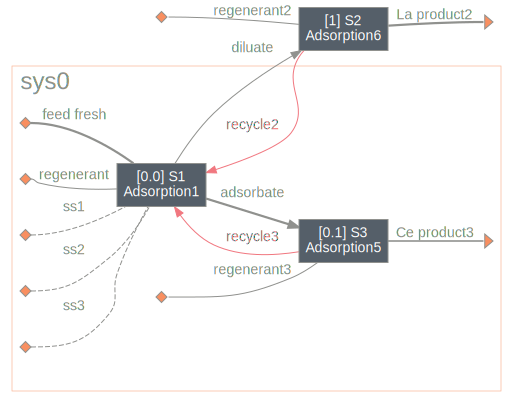

In [77]:
bst.main_flowsheet.clear() # Remove previous unit operations to prevent ID-conflict warnings
# Initialize starting parameters
CM1o = 0.01 # mM
CM2o = 0.01 # mM
feed_flow = 1/1000 # L/min

# Create and simulate the system 
# use qs.Flowsheet to connect LCA impact items to system streams
flowsheet = qs.Flowsheet.flowsheet.default
fs_stream = flowsheet.stream
fs_unit = flowsheet.unit

# Set up the unit
S1 = Adsorption1(ins=('feed_fresh', 'regenerant', 'recycle3', 'recycle2'), outs=('diluate', 'adsorbate'), c1o=CM1o, c2o=CM2o, feed_flow=feed_flow)
S1.simulate()
S2 = Adsorption6(ID='S2', ins=(S1-0, 'regenerant2'), outs=('La_product2', 3-S1)) 
S2.simulate()
S3 = Adsorption5(ID='S3', ins=(S1-1, 'regenerant3'), outs=(2-S1, 'Ce_product3')) 
S3.simulate()

sys0 = qs.System('sys0', path=(S1, S3), recycle=S3-0)
sys0.set_tolerance(mol=1e-11) # 1e-12
sys0.simulate()
sys1 = qs.System('sys1', path=(sys0, S2), recycle=S2-1)
sys1.set_tolerance(mol=1e-11)
sys1.simulate()
sys = sys1
sys.diagram(kind='cluster', number=True)

# tea = qs.TEA(system=sys, discount_rate=0.05, lifetime=1, simulate_system=False) # temporary TEA analysis

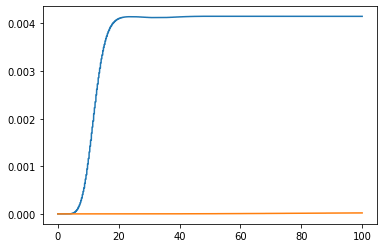

In [78]:
fig, ax = plt.subplots()
ax.plot(S2.time, S2.conc1[:,-1])
ax.plot(S2.time, S2.conc2[:,-1])

In [79]:
S2.tbreak

90.0

satisfied S1
S3
[<SanStream: recycle3>, <SanStream: Ce_product3>]
[<SanStream: Ce_product3>, <SanStream: La_product2>]
True


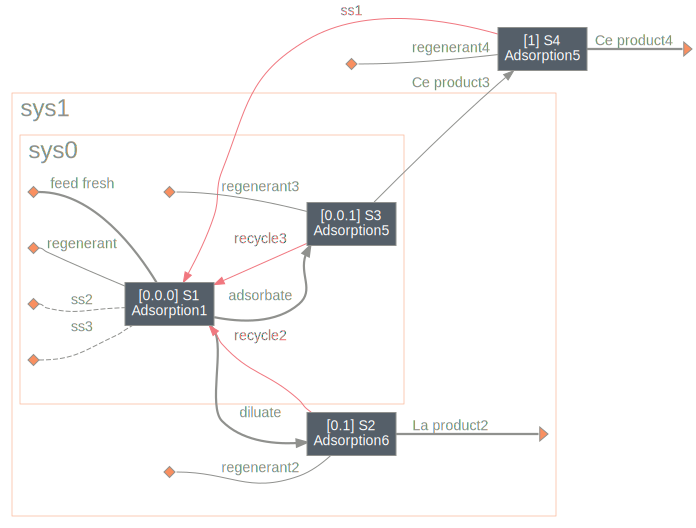

1
satisfied S2
satisfied S1
satisfied S3
satisfied S2
S4
[<SanStream: ss1>, <SanStream: Ce_product4>]
[<SanStream: La_product2>, <SanStream: Ce_product4>]
True


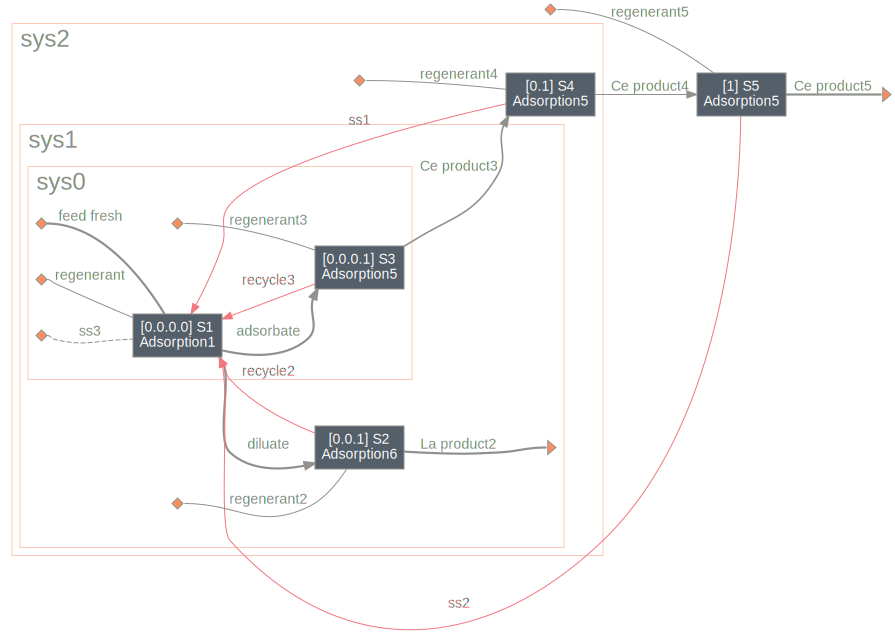

2


In [80]:
repetition = 0 
recycle_number = 3 # the number of the inlet streams into S1 after the initial simulation
sys_dct = {'sys0': sys0,
           'sys1': sys1}
unit_dct = {'S1': S1,
            'S2': S2,
            'S3': S3}

while 'pure La' and 'pure Ce' not in [i.tag for i in sys.units]:
    for unit in sys.units:
        if unit.tag == 'purifying Ce' and any(unit.outs[1] == string for string in sys.products): # len(unit.get_downstream_units())==0
            print(unit.ID)
            print(unit.outs)
            print(sys.products)
            print(unit.outs not in sys.products)
            # Create the next required unit and link it to the previous unit
            last_unit_name = max(unit_dct.keys(), key=lambda k: int(k[1:]))
            next_unit_number = int(last_unit_name[1:]) + 1
            next_unit_name = f'S{next_unit_number}'
            recycle_number = recycle_number+1
            # unit_dct[next_unit_name] = Adsorption5(ID=f'{next_unit_name}', ins=(unit_dct[last_unit_name]-1, f'regenerant{next_unit_number}'), outs=(f'recycle{next_unit_number}', f'Ce_product{next_unit_number}')) 
            unit_dct[next_unit_name] = Adsorption5(ID=f'{next_unit_name}', ins=(unit_dct[last_unit_name]-1, f'regenerant{next_unit_number}'), outs=(recycle_number-unit_dct['S1'], f'Ce_product{next_unit_number}')) 
            unit_dct[next_unit_name].simulate()

            # Incorporate this unit into an extended system
            last_sys_name = max(sys_dct.keys(), key=lambda k: int(k[3:]))
            next_sys_number = int(last_sys_name[3:]) + 1
            next_sys_name = f'sys{next_sys_number}'
            # sys_dct[next_sys_name] = qs.System(next_sys_name, path=(sys_dct[last_sys_name], unit_dct[next_unit_name]))
            sys_dct[next_sys_name] = qs.System(next_sys_name, path=(sys_dct[last_sys_name], unit_dct[next_unit_name]), recycle=unit_dct[next_unit_name]-0)
            sys_dct[next_sys_name].set_tolerance(mol=1e-11) # make tolerance flexible to different input conditions
            sys_dct[next_sys_name].simulate()

            # rename the new system to a common name for analysis
            sys = sys_dct[next_sys_name]
            sys.diagram(kind='cluster', number=True)

            repetition = repetition+1
            print(f'{repetition}')

        else:
            print(f'satisfied {unit.ID}')
            
tea = qs.TEA(system=sys, discount_rate=0.15, lifetime=1, simulate_system=False) # temporary TEA analysis


In [81]:
print(sys0._error_info())
print(sys1._error_info())
# print(sys2._error_info())
# print(sys3._error_info())
# print(sys4._error_info())

for system in sys_dct.values():
    print(system, system._error_info())


Highest convergence error among components in recycle
stream S3-0 after 1 loops:
- flow rate   2.74e-13 kmol/hr (0%)
- temperature 0.00e+00 K (0%)

Highest convergence error among components in recycle
stream S2-1 after 1 loops:
- flow rate   2.74e-13 kmol/hr (0%)
- temperature 0.00e+00 K (0%)
sys0 
Highest convergence error among components in recycle
stream S3-0 after 1 loops:
- flow rate   2.74e-13 kmol/hr (0%)
- temperature 0.00e+00 K (0%)
sys1 
Highest convergence error among components in recycle
stream S2-1 after 1 loops:
- flow rate   2.74e-13 kmol/hr (0%)
- temperature 0.00e+00 K (0%)
sys2 
Highest convergence error among components in recycle
stream S4-0 after 1 loops:
- flow rate   3.83e-13 kmol/hr (0%)
- temperature 0.00e+00 K (0%)
sys3 
Highest convergence error among components in recycle
stream S5-0 after 2 loops:
- flow rate   3.83e-13 kmol/hr (0%)
- temperature 0.00e+00 K (0%)


In [ ]:
unit_dct['S5'].tag

'pure Ce'

In [82]:
print('System Results')
# print('FCI', round(tea.FCI, 6))
print('---------------------')
print('Design Results')
# print(S1.results())
# print('')
# print(S2.results())
# print('')
# print(S3.results())
# print('')
# print(S4.results())
# print('')
# print(S5.results())
print('---------------------')
print('La')
print('S1 La Diluate Purity', fs_stream.diluate.imass['La']/(fs_stream.diluate.imass['La']+fs_stream.diluate.imass['Ce'])) # purity of Lanthanum stream
print('S2 La Product Purity', fs_stream.La_product2.imass['La']/(fs_stream.La_product2.imass['La']+fs_stream.La_product2.imass['Ce'])) # purity of Lanthanum stream
print('---------------------')
print('Ce')
print('S1 Ce adsorbate Purity', fs_stream.adsorbate.imass['Ce']/(fs_stream.adsorbate.imass['La']+fs_stream.adsorbate.imass['Ce']))
print('S3 Ce Purity', fs_stream.Ce_product3.imass['Ce']/(fs_stream.Ce_product3.imass['La']+fs_stream.Ce_product3.imass['Ce']))
print('S4 Ce Purity', fs_stream.Ce_product4.imass['Ce']/(fs_stream.Ce_product4.imass['La']+fs_stream.Ce_product4.imass['Ce']))
print('S5 Ce Purity', fs_stream.Ce_product5.imass['Ce']/(fs_stream.Ce_product5.imass['La']+fs_stream.Ce_product5.imass['Ce']))
# print('S6 Ce Purity', fs_stream.Ce_product6.imass['Ce']/(fs_stream.Ce_product6.imass['La']+fs_stream.Ce_product6.imass['Ce']))
print('---------------------')
outlet_REE = []
for i in sys_dct[next_sys_name].outs:
    if 'recycle' not in i.ID:
        outlet_REE.append(i.imass['La']+i.imass['Ce'])
print('REE Recovery ', np.sum(np.fromiter([i for i in outlet_REE], dtype=list))/(fs_stream.feed_fresh.imass['La']+fs_stream.feed_fresh.imass['Ce'])*100, '%')

System Results
---------------------
Design Results
---------------------
La
S1 La Diluate Purity 0.9889305100386071
S2 La Product Purity 0.9982334274220954
---------------------
Ce
S1 Ce adsorbate Purity 0.4716132597315094
S3 Ce Purity 0.8448137446850719
S4 Ce Purity 0.973164725038191
S5 Ce Purity 0.9900802288058287
---------------------
REE Recovery  99.81878802030624 %


In [ ]:
print('regenerant  (g/hr)  |  ', 'La', fs_stream.regenerant.imass['La']*1000, '   ', 'Ce', fs_stream.regenerant.imass['Ce']*1000, '   ', 'water', fs_stream.regenerant.imass['H2O']*1000)
print('regenerant2  (g/hr)  |  ', 'La', fs_stream.regenerant2.imass['La']*1000, '   ', 'Ce', fs_stream.regenerant2.imass['Ce']*1000, '   ', 'water', fs_stream.regenerant2.imass['H2O']*1000)
print('regenerant3  (g/hr)  |  ', 'La', fs_stream.regenerant3.imass['La']*1000, '   ', 'Ce', fs_stream.regenerant3.imass['Ce']*1000, '   ', 'water', fs_stream.regenerant3.imass['H2O']*1000)
# print('regenerant4  (g/hr)  |  ', 'La', fs_stream.regenerant4.imass['La']*1000, '   ', 'Ce', fs_stream.regenerant4.imass['Ce']*1000, '   ', 'water', fs_stream.regenerant4.imass['H2O']*1000)
# print('regenerant5  (g/hr)  |  ', 'La', fs_stream.regenerant5.imass['La']*1000, '   ', 'Ce', fs_stream.regenerant5.imass['Ce']*1000, '   ', 'water', fs_stream.regenerant5.imass['H2O']*1000)
print('feed_fresh  (g/hr)  |  ', 'La', fs_stream.feed_fresh.imass['La']*1000, '   ', 'Ce', fs_stream.feed_fresh.imass['Ce']*1000, '   ', 'water', fs_stream.feed_fresh.imass['H2O']*1000)
# print('adsorbate  (g/hr)  |  ', 'La', fs_stream.adsorbate.imass['La']*1000, '   ', 'Ce', fs_stream.adsorbate.imass['Ce']*1000, '   ', 'water', fs_stream.adsorbate.imass['H2O']*1000)
print('La_product  (g/hr)  |  ', 'La', fs_stream.La_product2.imass['La']*1000, '   ', 'Ce', fs_stream.La_product2.imass['Ce']*1000, '   ', 'water', fs_stream.La_product2.imass['H2O']*1000)
# print('recycle    (g/hr)  |  ', 'La', fs_stream.recycle.imass['La']*1000, '  ', 'Ce', fs_stream.recycle.imass['Ce']*1000, '   ', 'water', fs_stream.recycle.imass['H2O']*1000)
# print('recycle4    (g/hr)  |  ', 'La', fs_stream.recycle4.imass['La']*1000, '  ', 'Ce', fs_stream.recycle4.imass['Ce']*1000, '   ', 'water', fs_stream.recycle4.imass['H2O']*1000)
print('Ce_product3 (g/hr)  |  ', 'La', fs_stream.Ce_product4.imass['La']*1000, '   ', 'Ce', fs_stream.Ce_product4.imass['Ce']*1000, '  ', 'water', fs_stream.Ce_product4.imass['H2O']*1000)

regenerant  (g/hr)  |   La 0.0     Ce 0.0     water 59.82386875356651
regenerant2  (g/hr)  |   La 0.0     Ce 0.0     water 79.76515833808867
regenerant3  (g/hr)  |   La 0.0     Ce 0.0     water 59.82386875356651
feed_fresh  (g/hr)  |   La 8.334330000000001e-05     Ce 8.406960000000001e-05     water 59.82386875356651
La_product  (g/hr)  |   La 8.244377381465846e-05     Ce 8.40127485274092e-07     water 319.06063335235467
Ce_product3 (g/hr)  |   La 1.941967081626851e-06     Ce 8.96822860565266e-05    water 59.82386875356651


In [ ]:
print('Mass Balances (percentage of total inlet mass)')
print('')
print('Individual Units')
print('--La--')
print('S1 |', (np.sum([i.imass['La'] for i in unit_dct['S1'].outs]) - np.sum([i.imass['La'] for i in unit_dct['S1'].ins]))  /unit_dct['S1'].ins[0].imass['La']*100) # dividing by the feed mass of each component to see the error as a percentage
print('S2 |', (np.sum([i.imass['La'] for i in unit_dct['S2'].outs]) - np.sum([i.imass['La'] for i in unit_dct['S2'].ins]))  /unit_dct['S1'].ins[0].imass['La']*100)
print('S3 |', (np.sum([i.imass['La'] for i in unit_dct['S3'].outs]) - np.sum([i.imass['La'] for i in unit_dct['S3'].ins]))  /unit_dct['S1'].ins[0].imass['La']*100)
print('S4 |', (np.sum([i.imass['La'] for i in unit_dct['S4'].outs]) - np.sum([i.imass['La'] for i in unit_dct['S4'].ins]))  /unit_dct['S1'].ins[0].imass['La']*100)
print('S5 |', (np.sum([i.imass['La'] for i in unit_dct['S5'].outs]) - np.sum([i.imass['La'] for i in unit_dct['S5'].ins]))  /unit_dct['S1'].ins[0].imass['La']*100)
print('--Ce--')
print('S1 |', (np.sum([i.imass['Ce'] for i in unit_dct['S1'].outs]) - np.sum([i.imass['Ce'] for i in unit_dct['S1'].ins]))  /unit_dct['S1'].ins[0].imass['Ce']*100)
print('S2 |', (np.sum([i.imass['Ce'] for i in unit_dct['S2'].outs]) - np.sum([i.imass['Ce'] for i in unit_dct['S2'].ins]))  /unit_dct['S1'].ins[0].imass['Ce']*100)
print('S3 |', (np.sum([i.imass['Ce'] for i in unit_dct['S3'].outs]) - np.sum([i.imass['Ce'] for i in unit_dct['S3'].ins]))  /unit_dct['S1'].ins[0].imass['Ce']*100)
print('S4 |', (np.sum([i.imass['Ce'] for i in unit_dct['S4'].outs]) - np.sum([i.imass['Ce'] for i in unit_dct['S4'].ins]))  /unit_dct['S1'].ins[0].imass['Ce']*100)
print('S5 |', (np.sum([i.imass['Ce'] for i in unit_dct['S5'].outs]) - np.sum([i.imass['Ce'] for i in unit_dct['S5'].ins]))  /unit_dct['S1'].ins[0].imass['Ce']*100)
print('--Water--')
print('S1 |', (np.sum([i.imass['H2O'] for i in unit_dct['S1'].outs]) - np.sum([i.imass['H2O'] for i in unit_dct['S1'].ins]))  /unit_dct['S1'].ins[0].imass['H2O']*100) # dividing by the feed mass of each component to see the error as a percentage
print('S2 |', (np.sum([i.imass['H2O'] for i in unit_dct['S2'].outs]) - np.sum([i.imass['H2O'] for i in unit_dct['S2'].ins]))  /unit_dct['S1'].ins[0].imass['H2O']*100)
print('S3 |', (np.sum([i.imass['H2O'] for i in unit_dct['S3'].outs]) - np.sum([i.imass['H2O'] for i in unit_dct['S3'].ins]))  /unit_dct['S1'].ins[0].imass['H2O']*100)
print('S4 |', (np.sum([i.imass['H2O'] for i in unit_dct['S4'].outs]) - np.sum([i.imass['H2O'] for i in unit_dct['S4'].ins]))  /unit_dct['S1'].ins[0].imass['H2O']*100)
print('S5 |', (np.sum([i.imass['H2O'] for i in unit_dct['S5'].outs]) - np.sum([i.imass['H2O'] for i in unit_dct['S5'].ins]))  /unit_dct['S1'].ins[0].imass['H2O']*100)
print('')
print('Overall System (sys)')
print('--La--')
print((np.sum([i.imass['La'] for i in sys.outs]) - np.sum([i.imass['La'] for i in sys.ins]))  /unit_dct['S1'].ins[0].imass['La']*100) # /8.33e-08
print('--Ce--')
print((np.sum([i.imass['Ce'] for i in sys.outs]) - np.sum([i.imass['Ce'] for i in sys.ins]))  /unit_dct['S1'].ins[0].imass['Ce']*100)
print('--Water--')
print((np.sum([i.imass['H2O'] for i in sys.outs]) - np.sum([i.imass['H2O'] for i in sys.ins]))  /unit_dct['S1'].ins[0].imass['H2O']*100)

system_num = 'sys1'
print(f'Overall System ({system_num})')
print('--La--')
print((np.sum([i.imass['La'] for i in sys_dct[system_num].outs]) - np.sum([i.imass['La'] for i in sys_dct[system_num].ins]))  /unit_dct['S1'].ins[0].imass['La']*100) # /8.33e-08
print('--Ce--')
print((np.sum([i.imass['Ce'] for i in sys_dct[system_num].outs]) - np.sum([i.imass['Ce'] for i in sys_dct[system_num].ins]))  /unit_dct['S1'].ins[0].imass['Ce']*100)
print('--Water--')
print((np.sum([i.imass['H2O'] for i in sys_dct[system_num].outs]) - np.sum([i.imass['H2O'] for i in sys_dct[system_num].ins]))  /unit_dct['S1'].ins[0].imass['H2O']*100)

Mass Balances (percentage of total inlet mass)

Individual Units
--La--
S1 | 0.044315470744848165
S2 | -0.013766567957166227
S3 | -0.04335917944894617
S4 | -0.008104198662043255
S5 | -0.0022826510588845037
--Ce--
S1 | -0.1700246220119262
S2 | -0.000919421229027289
S3 | -0.22334659401460338
S4 | -0.12074156820389102
S5 | -0.11820833180088439
--Water--
S1 | 0.0
S2 | 0.0
S3 | 0.0
S4 | 0.0
S5 | 0.0

Overall System (sys)
--La--
-0.023197126382170405
--Ce--
-0.6332405372603235
--Water--
0.0
Overall System (sys1)
--La--
-0.012810276661248354
--Ce--
-0.3942906372555638
--Water--
0.0


In [ ]:
unit_dct['S1'].show()

Adsorption1: S1
ins...
[0] feed_fresh
phase: 'l', T: 298.15 K, P: 101325 Pa
flow (g/hr): H2O  59.8
                La   8.33e-05
                Ce   8.41e-05
[1] regenerant
phase: 'l', T: 298.15 K, P: 101325 Pa
flow (g/hr): H2O  59.8
[2] recycle3  from  Adsorption5-S3
phase: 'l', T: 298.15 K, P: 101325 Pa
flow (g/hr): H2O  59.8
                La   2.88e-05
                Ce   6.48e-05
[3] recycle2  from  Adsorption6-S2
phase: 'l', T: 298.15 K, P: 101325 Pa
flow (g/hr): H2O  79.8
                La   1.57e-05
                Ce   6.96e-06
[4] ss1  from  Adsorption5-S4
phase: 'l', T: 298.15 K, P: 101325 Pa
flow (g/hr): H2O  59.8
                La   7.3e-06
                Ce   3.95e-05
[5] ss2  from  Adsorption5-S5
phase: 'l', T: 298.15 K, P: 101325 Pa
flow (g/hr): H2O  59.8
                La   1.11e-06
                Ce   7.11e-06
[6] ss3
phase: 'l', T: 298.15 K, P: 101325 Pa
flow: 0
outs...
[0] diluate  to  Adsorption6-S2
phase: 'l', T: 298.15 K, P: 101325 Pa
flow (g/hr): H2O  31

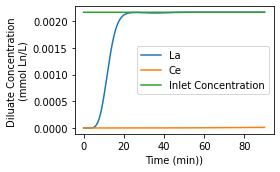

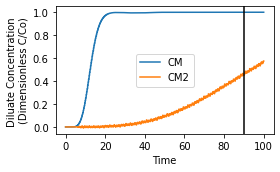

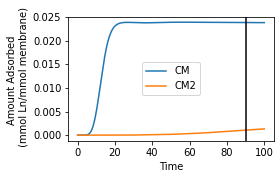

In [83]:
unit = unit_dct['S2']
time_ind = int(unit.tbreak/max(unit.time)*len(unit.time)) # index. The index of time at the designated stop of adsorption

fig, ax = plt.subplots(figsize=(4,2.5))
ax.plot(unit.time[:time_ind], unit.conc1[:time_ind,-2], label='La')
ax.plot(unit.time[:time_ind], unit.conc2[:time_ind,-2], label='Ce')
ax.plot(unit.time[:time_ind], [unit.CM1o]*len(unit.time[:time_ind]), label='Inlet Concentration')

ax.set_xlabel('Time (min))')
ax.set_ylabel('Diluate Concentration \n(mmol Ln/L)')
ax.legend()
fig.tight_layout()

# Plot breakthrough curves
fig, ax = plt.subplots(figsize=(4,2.5))
cend = unit.conc1[:, -1]  # get the outlet concentration at the full thickness of the membrane
cplot = cend / unit.CM1o  # make the outlet concentration a dimensionless form of the original concentration
ax.plot(unit.time, cplot, label='CM')

cend2 = unit.conc2[:, -1]  # get the outlet concentration at the full thickness of the membrane for CM2
cplot2 = cend2 / unit.CM2o  # make the outlet concentration a dimensionless form of the original concentration for CM2
ax.plot(unit.time, cplot2, label='CM2')

ax.axvline(x=unit.tbreak, color='black')

ax.set_xlabel('Time')
ax.set_ylabel('Diluate Concentration \n(Dimensionless C/Co)')
ax.legend()
fig.tight_layout()

# Plot breakthrough curves
fig, ax = plt.subplots(figsize=(4,2.5))
ax.plot(unit.time, unit.Qads1[:,-2], label='CM')
ax.plot(unit.time, unit.Qads2[:,-2], label='CM2')

ax.axvline(x=unit.tbreak, color='black')

ax.set_xlabel('Time')
ax.set_ylabel('Amount Adsorbed \n (mmol Ln/mmol membrane)')
ax.legend()
fig.tight_layout()

# Make sure molar volumes are correct especially for Ce

In [ ]:
fs_stream.diluate.ivol['La']

1.6517658549177248e-11

In [ ]:
fs_stream.diluate.ivol['Ce']

1.1529919431675865e-12

In [ ]:
Cerium.V

VolumeSolid(CASRN="7440-45-1", MW=140.116, Tt=1072.15, Vml_Tt=2.1391744834475658e-05, extrapolation="linear", method="USER_METHOD")